In [1]:
import scipy.io as sio
import seaborn as sns
import numpy as np
import pandas as pd
import math
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cplAE_MET.utils.analysis_helpers as proc_utils
from cplAE_MET.utils.load_config import load_config

from sklearn.decomposition import PCA
import numpy as np
from cplAE_MET.utils.plots import plot_m

/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_paths(config_file=None):
    paths = load_config(config_file=config_file, verbose=False)

    paths['input'] = f'{str(paths["data_dir"])}'
    paths['arbor_density_file'] = f'{paths["input"]}/{str(paths["arbor_density_file"])}'
    paths['arbor_density_PC_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_file"])}'
    paths['arbor_density_PC_vars_file'] = f'{paths["input"]}/{str(paths["arbor_density_PC_vars_file"])}'


    paths['specimen_ids'] = f'{paths["input"]}/{str(paths["specimen_ids_file"])}'

    paths['E_timeseries'] = f'{paths["input"]}/{str(paths["E_timeseries_file"])}'
    paths['ipfx_features'] = f'{paths["input"]}/{str(paths["ipfx_features_file"])}'
    paths['e_output'] = f'{paths["input"]}/{str(paths["e_output_file"])}'
    return paths

In [3]:
dir_pth = set_paths(config_file="config_preproc.toml")

ids = pd.read_csv(dir_pth['specimen_ids'])
specimen_ids = ids['specimen_id'].tolist()
print("...................................................")
print("There are", len(specimen_ids), "sample_ids in the locked dataset")


print("...................................................")
print("Loading M arbor_densities")
m_input = sio.loadmat(dir_pth['arbor_density_file'])


arbor_ids = [mystr.rstrip() for mystr in m_input['specimen_id']]
print("Number of cells in arbor density file:", len(arbor_ids))

print("...................................................")
print(len([i for i in specimen_ids if i not in arbor_ids]), "cells do not have arbor density data!")

...................................................
There are 7158 sample_ids in the locked dataset
...................................................
Loading M arbor_densities
Number of cells in arbor density file: 7158
...................................................
0 cells do not have arbor density data!


In [4]:
print("...................................................")
print("keeping only ids that are inside specimen id list")
mask_arbor_ids = [True if i in specimen_ids else False for i in arbor_ids]
arbor_ids = [b for a, b in zip(mask_arbor_ids, arbor_ids) if a]
print("In total remains this amount of cells:", sum(mask_arbor_ids))

print("...................................................")
print("masking each arbor density channel and putting each channel in one specific key of a dict")
soma_depth = np.squeeze(m_input['soma_depth'])[mask_arbor_ids]
arbor_density = {}
arbor_density['ax'] = m_input['hist_ax_de_api_bas'][:,:,:,0][mask_arbor_ids]
arbor_density['de'] = m_input['hist_ax_de_api_bas'][:,:,:,1][mask_arbor_ids]
arbor_density['api'] = m_input['hist_ax_de_api_bas'][:,:,:,2][mask_arbor_ids]
arbor_density['bas'] = m_input['hist_ax_de_api_bas'][:,:,:,3][mask_arbor_ids]

...................................................
keeping only ids that are inside specimen id list
In total remains this amount of cells: 7158
...................................................
masking each arbor density channel and putting each channel in one specific key of a dict


In [5]:
print("...................................................")
print("create a 1d mask for each arbor density channel")
# in the arbor density file, if a cell does not have M data, all the channels are nan values
# if a cell is exc, the ax and de (first two channels) are all zeros and the api and bas (second 
# two channels) have values. This mask is to find the exc cells with M data and inh cells with M data. 
# so if all channels are nan, then it will return False. 

not_valid_xm_channels = np.apply_over_axes(np.all, 
                                            np.logical_or(m_input['hist_ax_de_api_bas'] == 0, 
                                            np.isnan(m_input['hist_ax_de_api_bas'])),
                                            axes = [1, 2])
not_valid_xm_channels = np.squeeze(not_valid_xm_channels)
valid={}
valid['ax'] = ~not_valid_xm_channels[:,0]
valid['de']= ~not_valid_xm_channels[:,1]
valid['api'] = ~not_valid_xm_channels[:,2]
valid['bas']= ~not_valid_xm_channels[:,3]


...................................................
create a 1d mask for each arbor density channel


...................................................
PCA analysis 


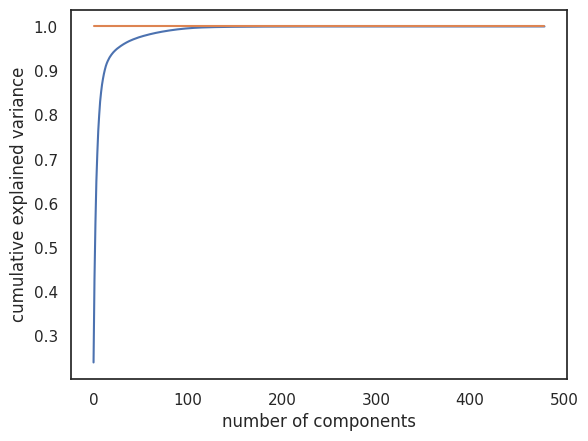

12


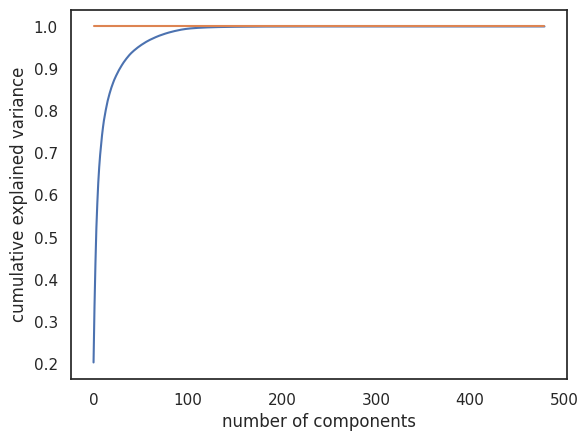

28


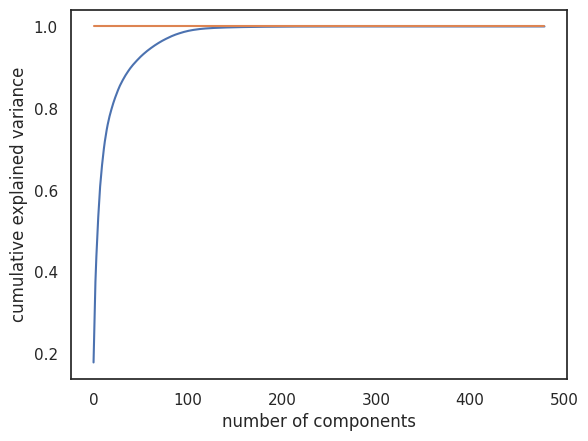

40


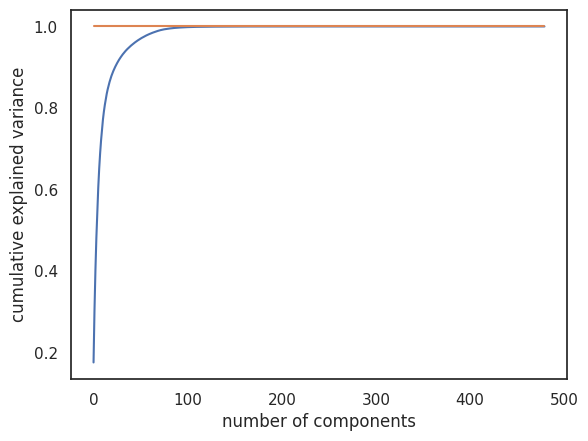

23
ax (971, 12)
de (971, 28)
api (1192, 40)
bas (1192, 23)
...................................................
Scaling PCA features


In [6]:
# Now for each channel, we mask for the valid cells and then we look if there is any
# nan value in the cells arbor densities. If there is any nan, we should either 
# remove that cell or put that nan to zero for that channel
keep_cells = {}
for k in arbor_density.keys():
    # mask for the cells with arbor density
    arbor_density[k] = arbor_density[k][valid[k]]
    # Find the m_cells with that have nan values in their non-OFF channels
    keep_cells[k] = ~np.squeeze(np.apply_over_axes(np.any, np.isnan(arbor_density[k]),axes = [1, 2]))
    # remove the cells that have nan values in each channel
    arbor_density[k] = arbor_density[k][keep_cells[k]]
    # collapse the last to dim and have a 1d arbor density for each channel
    arbor_density[k] = arbor_density[k].reshape(arbor_density[k].shape[0], -1)


print("...................................................")
print("PCA analysis ")
n_comp_at_thr={}
for k in arbor_density.keys():
    n_comp_at_thr[k] = proc_utils.get_PCA_explained_variance_ratio_at_thr(nparray=arbor_density[k], threshold=0.9)
    if n_comp_at_thr[k] == 0:
        n_comp_at_thr[k] = 1
    # if n_comp_at_thr[k]> 20:
    #     n_comp_at_thr[k] = 20

    print(n_comp_at_thr[k])

PC = {}
for k in arbor_density.keys():
    if k != "ids":
        pca = PCA(n_comp_at_thr[k])
        PC[k] = pca.fit_transform(arbor_density[k])
        print(k, PC[k].shape)

print("...................................................")
print("Scaling PCA features")
#Scaling PC features
Scaled_PCs = {}
total_var = pd.DataFrame(columns=PC.keys())

for k in PC.keys():
    v = np.sqrt(np.sum(pd.DataFrame(PC[k]).var(axis=0)))
    Scaled_PCs[k] = PC[k] / v
    total_var.loc[0, k] = v

...................................................
Removing outliers whithin 6 std from scaled PCs


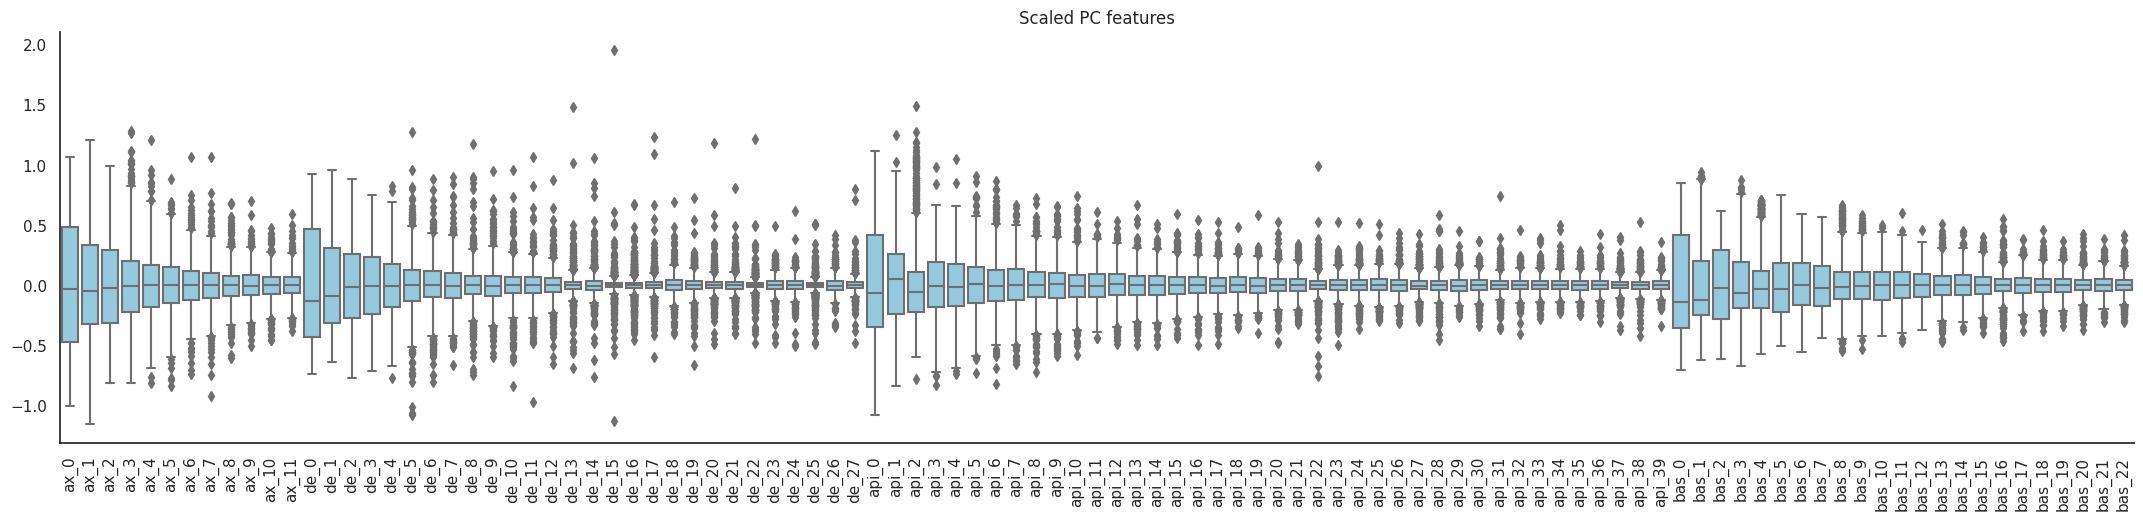

Scaled PCs size: (2163, 104)
...................................................
adding soma depth to the features


In [7]:
print("...................................................")
print("Removing outliers whithin 6 std from scaled PCs")
#attaching specimen ids and removing outliers
for k in PC.keys():
    Scaled_PCs[k] = pd.DataFrame(Scaled_PCs[k])
    scaling_thr = np.abs(np.max(Scaled_PCs[k].std(axis=0, skipna=True, numeric_only=True)) * 6)
    Scaled_PCs[k] = Scaled_PCs[k][(Scaled_PCs[k] < scaling_thr) & (Scaled_PCs[k] > -1 * scaling_thr)]
    Scaled_PCs[k].columns = [k + "_" + str(i) for i in range(Scaled_PCs[k].shape[1])]
    valid_ids = [id for i, id in enumerate(arbor_ids) if valid[k][i]]
    valid_ids = [id for i, id in enumerate(valid_ids) if keep_cells[k][i]]
    Scaled_PCs[k]["specimen_id"] = valid_ids
    Scaled_PCs[k]['specimen_id'] = Scaled_PCs[k]['specimen_id'].astype(str)

#Merge all scaled PC features into one df
data_frames = []
for k in Scaled_PCs.keys():
    data_frames.append(Scaled_PCs[k])

Scaled_PCs = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='outer'), data_frames)

df = Scaled_PCs.melt(value_vars=Scaled_PCs[[c for c in Scaled_PCs.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled PC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

print("Scaled PCs size:", Scaled_PCs.shape)
print("...................................................")
print("adding soma depth to the features")
m_cells = ~np.isnan(soma_depth)
m_cells = [id for i, id in enumerate(arbor_ids) if m_cells[i]]

sd = pd.DataFrame({"specimen_id": m_cells, "soma_depth": soma_depth[~np.isnan(soma_depth)]})

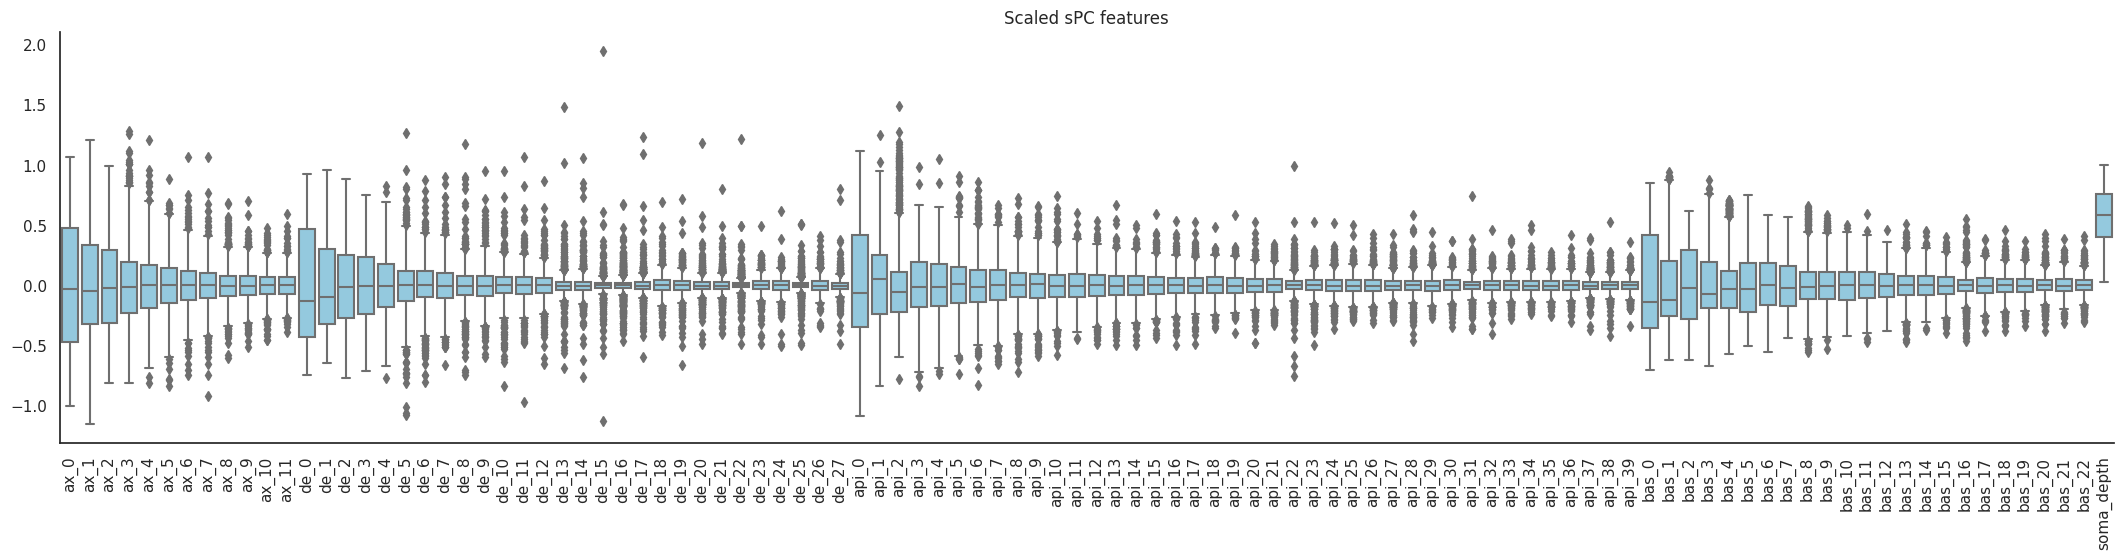

Size of Merged PCs features: (7158, 105)
Done


In [8]:
data_frames = [Scaled_PCs, sd]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['specimen_id'], how='inner'), data_frames)
df_merged = df_merged.merge(pd.DataFrame(specimen_ids, columns=["specimen_id"]), on="specimen_id", how='right')

# Make sure the order is the same as th
df_merged = df_merged.set_index('specimen_id')
df_merged = df_merged.loc[specimen_ids].reset_index()
f = df_merged
df = f.melt(value_vars=f[[c for c in f.columns if c != "specimen_id"]])
sns.catplot(x="variable", y="value", kind='box', data=df, palette=sns.color_palette(["skyblue"]), aspect=4.4)
ax = plt.gca()
ax.set(**{'title': 'Scaled sPC features', 'xlabel': '', 'ylabel': ''})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

print("Size of Merged PCs features:", df_merged.shape)
print("Done")

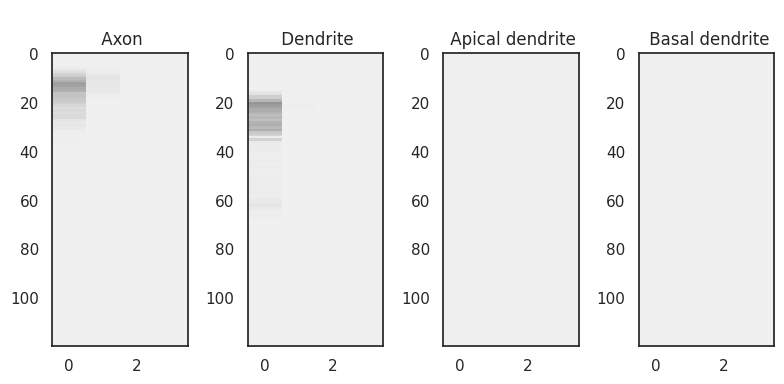

In [28]:
plot_m(m_input['hist_ax_de_api_bas'][2400])

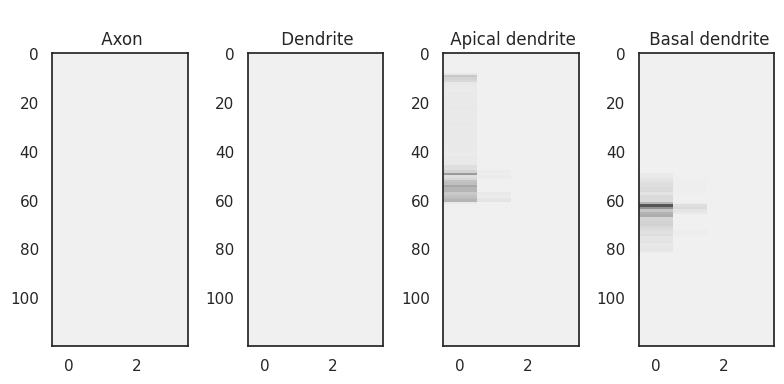

In [19]:
plot_m(m_input['hist_ax_de_api_bas'][350])